<a href="https://colab.research.google.com/github/HdNathanael/deep_learning_pd/blob/main/Homework_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework_01 - Nathanael Schmidt-Ott

In [33]:
!git push

fatal: could not read Username for 'https://github.com': No such device or address


## Load Framework

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import os
import tqdm
import fastprogress

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler
import torch.nn.functional as F

from sklearn.model_selection import KFold

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
% cd /content/gdrive/MyDrive/NNDL_PD/deep_learning_pd/
!git pull

/content/gdrive/MyDrive/NNDL_PD/deep_learning_pd
Already up to date.


In [5]:
from torch_framework.MLP import MLP
from torch_framework.aux import *
from torch_framework.train import *
from torch_framework.plot import *
from torch_framework.test import *

In [6]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [7]:
# create folders for results and plots if not already available
if not os.path.isdir('results'):
  print('create results folder')
  !mkdir results
if not os.path.isdir('plots'):
  print("create plot folder")
  !mkdir plots

# First Task - Regression


### Load data

In [8]:
if not os.path.isfile('regression_dataset/train_data.csv'):
  print("Downloading data...")
  !wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
  !wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 
else:
  print("Data already downloaded")

Data already downloaded


In [9]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

In [10]:
train_tensor = make_tensor(train_df)
train_loader = DataLoader(train_tensor, batch_size=20, shuffle=True, num_workers=0)

test_tensor = make_tensor(test_df)
test_loader = DataLoader(test_tensor, batch_size = 100, shuffle = False, num_workers = 0)

### Activation functions
Fit a simple multi-layer perceptron with two hidden layers and 25 hidden units each using stochastic gradient descent to compare activation functions.

Initialising training


Finished training after 3 seconds
Initialising training


Finished training after 3 seconds
Initialising training


Finished training after 3 seconds


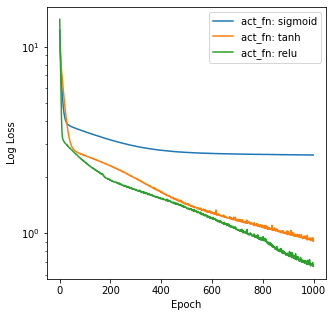

In [11]:
# set seed to make example reproducible
torch.manual_seed(123)
Ni, No = 1, 1
hidden_layer_params = {0:25,1:25}
sig = nn.Sigmoid
tanh = nn.Tanh
relu = nn.ReLU
n_epochs = 1000

# define the multi-layer perceptron
loss_fn = nn.MSELoss() # MSE loss since regression

mlp_sig = MLP(Ni,No,hidden_layer_params,act_fn = sig)
mlp_tanh = MLP(Ni,No,hidden_layer_params,act_fn = tanh)
mlp_relu = MLP(Ni,No, hidden_layer_params, act_fn = relu)
optimiser_sig = optim.SGD(mlp_sig.parameters(), lr = 1e-3)
optimiser_tanh = optim.SGD(mlp_tanh.parameters(), lr = 1e-3)
optimiser_relu = optim.SGD(mlp_relu.parameters(), lr = 1e-3)
# train the model
train_loss_sig = run_training_reg(n_epochs, mlp_sig, optimiser_sig, loss_fn, device, train_loader)
train_loss_tanh = run_training_reg(n_epochs, mlp_tanh, optimiser_tanh, loss_fn, device, train_loader)
train_loss_relu = run_training_reg(n_epochs, mlp_relu, optimiser_relu, loss_fn, device, train_loader)
# plot training loss on full data
plt.figure(figsize = (5,5))
plt.semilogy(train_loss_sig, label = "act_fn: sigmoid")
plt.semilogy(train_loss_tanh, label = "act_fn: tanh")
plt.semilogy(train_loss_relu, label = 'act_fn: relu')
plt.ylabel("Log Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("plots/act_fns.png")
plt.show()

As expected the hyperbolic tangent activation function outperforms the sigmoid activation function. Thus, in the following I will only use the hyperbolic tangent. 

### Compare different optimisers

Initialising training


Finished training after 3 seconds
Initialising training


Finished training after 4 seconds
Initialising training


Finished training after 5 seconds
Initialising training


Finished training after 4 seconds


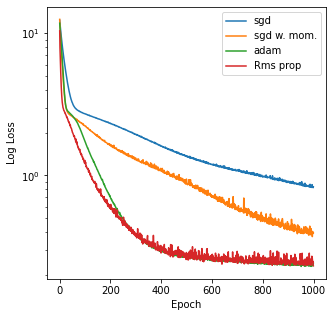

In [12]:
# set seed to make example reproducible
torch.manual_seed(123)
Ni, No = 1, 1
hidden_layer_params = {0:25,1:25}
act_fn = nn.Tanh
n_epochs = 1000

# define the multi-layer perceptron
mlp = MLP(Ni,No,hidden_layer_params,act_fn)
loss_fn = nn.MSELoss() # MSE loss since regression

# define different optimisers
sgd = optim.SGD(mlp.parameters(), lr = 1e-3)
sgd_mom = optim.SGD(mlp.parameters(), lr = 1e-3, momentum = 0.5)
adam = optim.Adam(mlp.parameters(), lr = 1e-3)
rms = optim.RMSprop(mlp.parameters(), lr = 1e-3)

# train the model
train_loss_sgd = run_training_reg(n_epochs, mlp, sgd, loss_fn, device, train_loader)
mlp.apply(weight_reset)
train_loss_sgd_mom = run_training_reg(n_epochs, mlp, sgd_mom, loss_fn, device, train_loader)
mlp.apply(weight_reset)
train_loss_adam = run_training_reg(n_epochs,mlp, adam, loss_fn, device, train_loader)
mlp.apply(weight_reset)
train_loss_rms = run_training_reg(n_epochs, mlp, rms, loss_fn, device, train_loader)

# plot training loss on full data
plt.figure(figsize = (5,5))
plt.semilogy(train_loss_sgd, label = "sgd")
plt.semilogy(train_loss_sgd_mom, label = "sgd w. mom.")
plt.semilogy(train_loss_adam,label = 'adam')
plt.semilogy(train_loss_rms, label = 'Rms prop')
plt.ylabel("Log Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("plots/optimisers.png")
plt.show()

### Compare different weight initialisation schemes

Initialising training


Finished training after 5 seconds
Initialising training


Finished training after 5 seconds
Initialising training


Finished training after 5 seconds


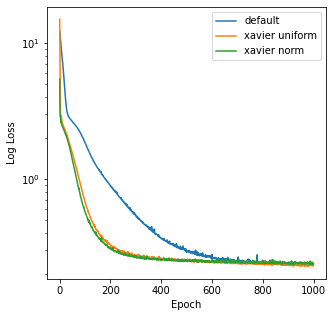

In [13]:
# set seed to make example reproducible
torch.manual_seed(123)
Ni, No = 1, 1
hidden_layer_params = {0:25,1:25}
act_fn = nn.Tanh
n_epochs = 1000

# define the multi-layer perceptron
loss_fn = nn.MSELoss() # MSE loss since regression

mlp = MLP(Ni,No,hidden_layer_params,act_fn)
optimiser = optim.Adam(mlp.parameters(), lr = 1e-3)

# train the model
train_loss_def = run_training_reg(n_epochs, mlp, optimiser, loss_fn, device, train_loader)
mlp.apply(init_weights_xavier_unif)
train_loss_unif = run_training_reg(n_epochs, mlp, optimiser, loss_fn, device, train_loader)
mlp.apply(init_weights_xavier_norm)
train_loss_norm = run_training_reg(n_epochs, mlp, optimiser, loss_fn, device, train_loader)

# plot training loss on full data
plt.figure(figsize = (5,5))
plt.semilogy(train_loss_def, label = 'default')
plt.semilogy(train_loss_unif, label = 'xavier uniform')
plt.semilogy(train_loss_norm, label = "xavier norm")
plt.ylabel("Log Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("plots/weight_init.png")
plt.show()

### batch size

batch size: 1
Initialising training


Finished training after 84 seconds
batch size: 10
Initialising training


Finished training after 9 seconds
batch size: 20
Initialising training


Finished training after 5 seconds
batch size: 50
Initialising training


Finished training after 2 seconds
batch size: 100
Initialising training


Finished training after 1 seconds


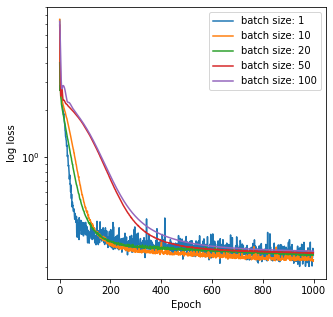

In [14]:
Ni, No = 1,1
hidden_layer_params = {0:25,1:25}
act_fn = nn.Tanh
n_epochs = 1000

mlp = MLP(Ni,No,hidden_layer_params,act_fn)
optimiser = optim.Adam(mlp.parameters(), lr = 1e-3)

batches = [1,10,20,50,100]
batch_results = np.zeros((len(batches),n_epochs))

for it, batch_size in enumerate(batches):
  train_load = DataLoader(train_tensor, batch_size = batch_size, shuffle = True, num_workers = 0)
  mlp.apply(init_weights_xavier_unif)
  print(f"batch size: {batches[it]}")
  batch_results[it,:] = run_training_reg(n_epochs, mlp, optimiser, loss_fn, device, train_load)

# plot results
plt.figure(figsize = (5,5))
for it,loss in enumerate(batch_results):
  lab = "batch size: "+str(batches[it])
  plt.semilogy(loss,label = lab)
plt.ylabel("log loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("plots/batch_sizes.png")
plt.show()

### Learning rate




Learning rate: 0.1
Initialising training


Finished training after 5 seconds
Learning rate: 0.01
Initialising training


Finished training after 5 seconds
Learning rate: 0.001
Initialising training


Finished training after 5 seconds
Learning rate: 0.0001
Initialising training


Finished training after 5 seconds


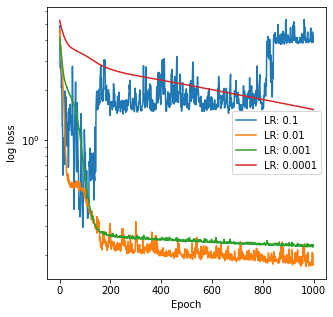

In [15]:
train_loader = DataLoader(train_tensor, batch_size = 20, shuffle = True, num_workers = 0)

Ni, No = 1,1
hidden_layer_params = {0:25,1:25}
act_fn = nn.Tanh
n_epochs = 1000

lrs = [1e-1,1e-2,1e-3,1e-4]
lr_results = np.zeros((len(lrs),n_epochs))


mlp = MLP(Ni,No,hidden_layer_params,act_fn)
for it, lr in enumerate(lrs):
  mlp.apply(init_weights_xavier_unif)
  optimiser = optim.Adam(mlp.parameters(), lr = lr)
  print(f"Learning rate: {lrs[it]}")
  lr_results[it,:] = run_training_reg(n_epochs, mlp, optimiser, loss_fn, device, train_loader)

# plot results
plt.figure(figsize = (5,5))
for it,loss in enumerate(lr_results):
  lab = "LR: "+str(lrs[it])
  plt.semilogy(loss,label = lab)
plt.ylabel("log loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("plots/learning_rates.png")
plt.show()

### Tune depth and width of network
The goal is to see how the generalisation error changes with the width and depth of the network.

In [ ]:
# first increase width of network (try out different parameters)
widths = [10,25,100,500,1000]

torch.manual_seed(123)
act_fn = nn.Tanh
n_epochs = 1000
n_folds = 5

train_loss_width = np.zeros((len(widths), n_folds, n_epochs))
val_loss_width = np.zeros((len(widths), n_folds, n_epochs))

Ni, No = 1, 1
loss_fn = nn.MSELoss()
for it,width in enumerate(widths):
  print(f"--- width:{width}")
  hidden_layer_params = {0:width,1:width}
  mlp = MLP(Ni,No,hidden_layer_params,act_fn)
  train_loss_width[it,:,:], val_loss_width[it,:,:] = k_fold_cv(n_folds, train_df, n_epochs, mlp, device, init_weights_xavier_unif,
              optimiser = optim.Adam, learning_rate = 1e-3, batch_size=20, random_state = 123)

--- width:10
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 4 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 4 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 5 seconds

Completed Cross Validation after 23 seconds
--- width:25
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 5 seconds

Completed Cross Validation after 23 seconds
--- width:100
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 5 seconds

Completed Cross Validation after 25 seconds
--- width:500
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 15 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 14 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 15 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 15 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 15 seconds

Completed Cross Validation after 73 seconds
--- width:1000
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 54 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 53 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 53 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 54 seconds

evaluating on fold 5 out of 5
Initialising training


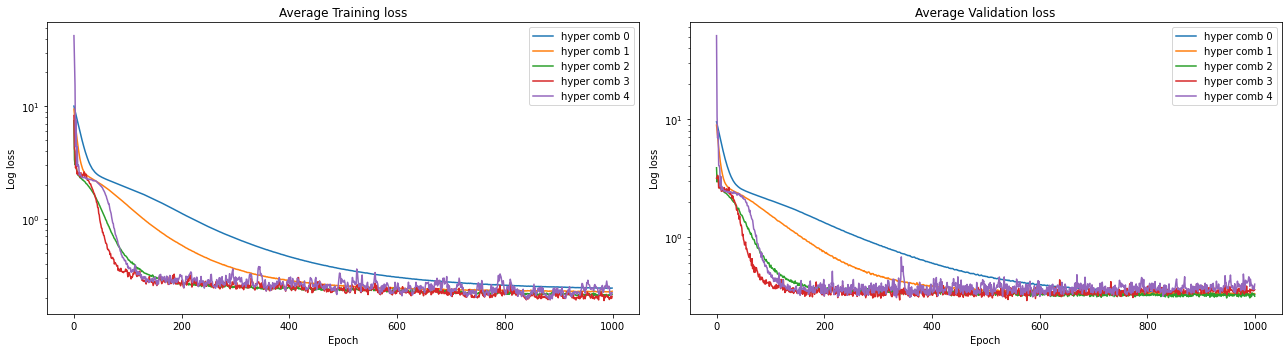

In [24]:
plot_cv_hyper(train_loss_width,val_loss_width)

In [25]:
# Check how depth of network influences the results
depths = [2,4,8,20]
torch.manual_seed(123)
act_fn = nn.Tanh
loss_fn = nn.MSELoss()
n_epochs = 1000
n_folds = 5
Ni, No = 1, 1

train_loss_depth = np.zeros((len(depths), n_folds, n_epochs))
val_loss_depth = np.zeros((len(depths), n_folds, n_epochs))

for it,depth in enumerate(depths):
  print(f"--- depth:{depth}")
  hidden_layer_params = dict(zip(list(range(depth)),np.repeat(25,depth)))
  mlp = MLP(Ni,No,hidden_layer_params, act_fn)
  train_loss_depth[it,:,:], val_loss_depth[it,:,:] = k_fold_cv(n_folds, train_df, n_epochs, mlp, device, init_weights_xavier_unif,
              optimiser = optim.Adam, learning_rate = 1e-3, batch_size=20, random_state = 123)

--- depth:2
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 10 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 10 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 10 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 10 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 10 seconds

Completed Cross Validation after 51 seconds
--- depth:4
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 15 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 15 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 15 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 15 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 15 seconds

Completed Cross Validation after 73 seconds
--- depth:8
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 23 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 24 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 23 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 24 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 23 seconds

Completed Cross Validation after 117 seconds
--- depth:20
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 49 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 49 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 50 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 49 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 49 seconds

Completed Cross Validation after 246 seconds


In [17]:
plot_cv_hyper(train_loss_depth,val_loss_depth)

NameError: ignored

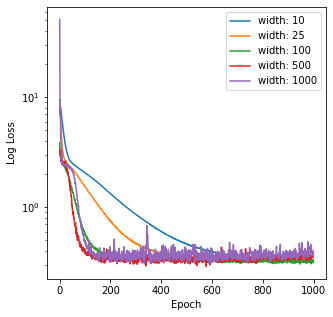

Comparing 5 models

Model	min loss	epoch	final loss
Model 0	0.33	983		0.33
Model 1	0.32	974		0.33
Model 2	0.30	947		0.32
Model 3	0.29	576		0.36
Model 4	0.31	334		0.40


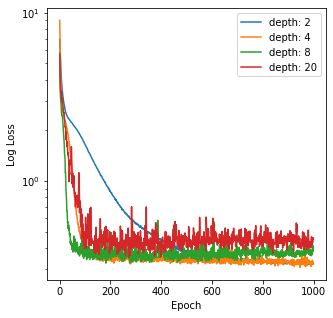

Comparing 4 models

Model	min loss	epoch	final loss
Model 0	0.32	974		0.33
Model 1	0.31	947		0.32
Model 2	0.32	182		0.40
Model 3	0.35	271		0.45


In [27]:
# create plots for report
# width
avg_val_loss_w = np.mean(val_loss_width,axis = 1)
plt.figure(figsize = (5,5))
for it,loss in enumerate(avg_val_loss_w):
  lab = "width: "+str(widths[it])
  plt.semilogy(loss,label = lab)
plt.ylabel("Log Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("plots/widths.png")
plt.show()

def get_best_mod(val_loss):
  print(f'Comparing {len(val_loss)} models\n')
  print("Model\tmin loss\tepoch\tfinal loss")
  for it, loss in enumerate(val_loss):
    print(f"Model {it}\t{np.min(loss):.2f}\t{np.argmin(loss)}\t\t{loss[-1]:.2f}")
get_best_mod(avg_val_loss_w)
# depth
avg_val_loss_d = np.mean(val_loss_depth, axis = 1)
plt.figure(figsize = (5,5))
for it,loss in enumerate(avg_val_loss_d):
  lab = 'depth: ' + str(depths[it])
  plt.semilogy(loss,label = lab)
plt.ylabel("Log Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("plots/depths.png")
plt.show()
get_best_mod(avg_val_loss_d)

We see that increasing both, width and depth of networks increases their accuracy. However, the results suggest that this only holds up to a certain point: for instance a rather deep network with 20 layers actually yields higher cross-validation error than a more shallow network with only 4 hidden layers. Generally speaking, wider networks appear to converge faster than more narrow network, which intuitively makes sense as the network has more weights and thus it can be adapted to the data more quickly. Note moreover, that in both cases as I increase the width or depth of the network, the loss starts oscillating. We observe this because with increasing complexity of the model, the model becomes more and more overparameterised. Thus, for a more complex model it is sensible to introduce regularisation such as dropout or weight decay. From these results, it appears to be sensible to introduce a shallow network with only 4 layers and 100 hidden units each. I will use this model specification to explore the benefit of regularisation in the following.

### Overfitting the training data



Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 21 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 21 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 22 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 21 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 21 seconds

Completed Cross Validation after 107 seconds


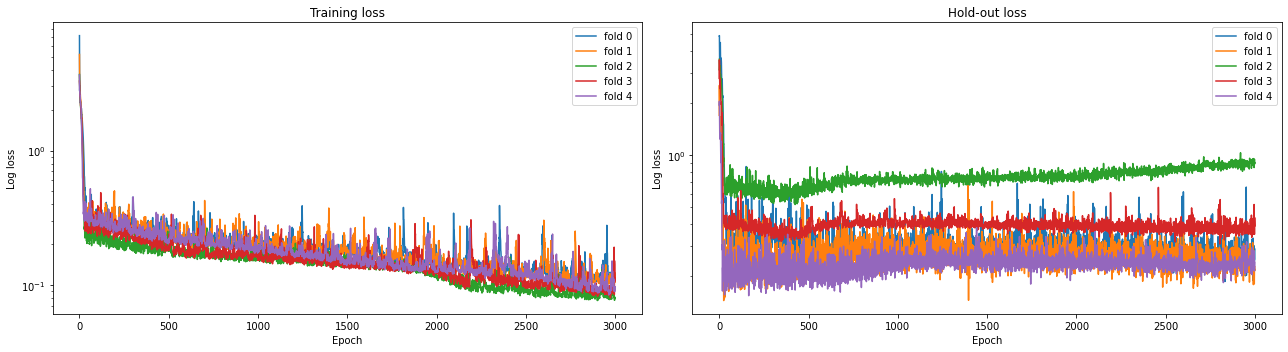

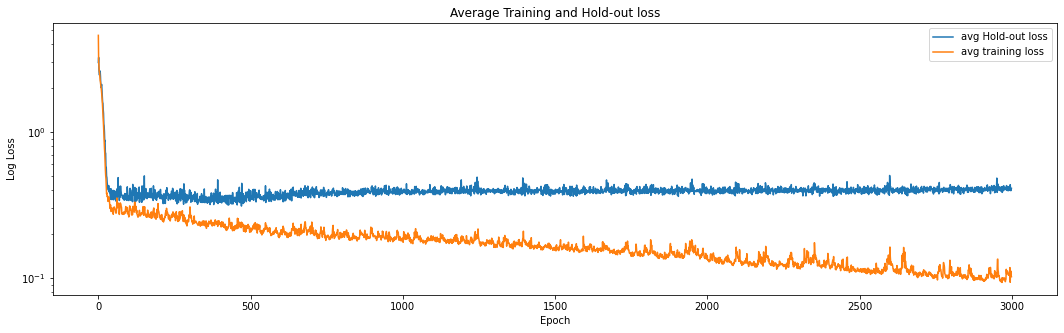

In [27]:
# uses same parameters as before, thus no need to specify
torch.manual_seed(123)

Ni, No = 1, 1
hidden_layer_params = {0:100,1:100,2:100,3:100}
act_fn = nn.Tanh
n_epochs = 3000

# define the multi-layer perceptron
loss_fn = nn.MSELoss() # MSE loss since regression
mlp = MLP(Ni,No,hidden_layer_params,act_fn)

# specify number of folds for k-fold cv
n_folds = 5

# initialise model using the same hyper parameters defined above
mlp_cv = MLP(Ni,No,hidden_layer_params,act_fn)

train_loss_cv, val_loss_cv = k_fold_cv(n_folds, train_df, n_epochs, mlp_cv, device, init_weights_xavier_unif,
              optimiser = optim.Adam, learning_rate = 1e-3, batch_size=20, random_state = 123)

plot_cv_results(train_loss_cv,val_loss_cv)

In [28]:
torch.manual_seed(123)

Ni, No = 1, 1
hidden_layer_params = {0:100,1:100,2:100,3:100}
act_fn = nn.Tanh
n_epochs = 3000

# define the multi-layer perceptron
loss_fn = nn.MSELoss() # MSE loss since regression
mlp = MLP(Ni,No,hidden_layer_params,act_fn)
mlp.apply(init_weights_xavier_unif)
optimiser = optim.Adam(mlp.parameters(),lr = 1e-3)

train_loss = run_training_reg(n_epochs,mlp,optimiser,loss_fn,device,train_loader)

Initialising training


Finished training after 23 seconds


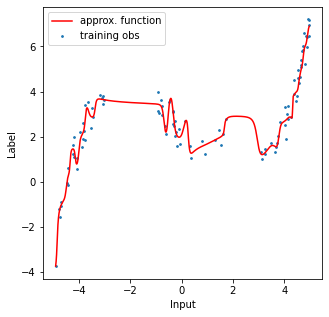

In [29]:
y_hat = predict_reg(train_df.input,mlp,device)
x_new = np.linspace(min(train_df.input),max(train_df.input),10000)
y_hat_new = predict_reg(x_new,mlp,device)
# plot for report
plt.figure(figsize = (5,5))
plt.scatter(train_df.input,train_df.label,label = 'training obs', s = 3)
plt.plot(x_new,y_hat_new,label = 'approx. function', color = "red")
plt.legend()
plt.xlabel('Input')
plt.ylabel('Label')
plt.savefig("plots/overfit.png")
plt.show()

### Regularise the model


In [31]:
torch.manual_seed(123)

Ni, No = 1, 1
hidden_layer_params = {0:100,1:100,2:100,3:100}
act_fn = nn.Tanh
n_epochs = 3000
n_folds = 5

# define the grid
do = np.array([0,0.001,0.01,0.1,0.2])
wd = np.array([0,0.001,0.005,0.01,0.1])
# this has the dropout rate first and wd second
combs = np.array(np.meshgrid(do,wd)).T.reshape(-1,2)

train_loss_reg, val_loss_reg = np.zeros((len(combs),n_folds,n_epochs)), np.zeros((len(combs),n_folds,n_epochs))

for it, comb in enumerate(combs):
  print(f"--- combination {it} of {len(combs)}")
  mlp = MLP(Ni,No,hidden_layer_params, act_fn, dropout = comb[0])
  train_loss_reg[it,:,:], val_loss_reg[it,:,:] = k_fold_cv(n_folds, train_df, n_epochs, mlp, device, weight_reset,
              optimiser = optim.Adam, learning_rate = 1e-3, wd = comb[1],batch_size=20, random_state = 123)


--- combination 0 of 25
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 73 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 73 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 73 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 73 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 73 seconds

Completed Cross Validation after 366 seconds
--- combination 1 of 25
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 77 seconds

Completed Cross Validation after 384 seconds
--- combination 2 of 25
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 76 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 76 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 77 seconds

Completed Cross Validation after 383 seconds
--- combination 3 of 25
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 76 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 77 seconds

Completed Cross Validation after 384 seconds
--- combination 4 of 25
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 77 seconds

Completed Cross Validation after 385 seconds
--- combination 5 of 25
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 76 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 77 seconds

Completed Cross Validation after 384 seconds
--- combination 6 of 25
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 80 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 80 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 80 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 80 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 81 seconds

Completed Cross Validation after 402 seconds
--- combination 7 of 25
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 80 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 81 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 80 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 80 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 80 seconds

Completed Cross Validation after 402 seconds
--- combination 8 of 25
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 81 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 80 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 81 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 81 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 81 seconds

Completed Cross Validation after 403 seconds
--- combination 9 of 25
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 81 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 80 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 80 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 81 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 80 seconds

Completed Cross Validation after 402 seconds
--- combination 10 of 25
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 77 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 77 seconds

Completed Cross Validation after 386 seconds
--- combination 11 of 25
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 81 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 81 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 81 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 81 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 81 seconds

Completed Cross Validation after 404 seconds
--- combination 12 of 25
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 80 seconds

evaluating on fold 2 out of 5
Initialising training


KeyboardInterrupt: ignored

In [ ]:
# get the best model based on the lowest validation loss
regu_loss = np.mean(val_loss_reg, axis = 1)
# plot the 5 best performing combinations
best_idx = np.argsort(np.min(regu_loss,axis = 1))[:5]
best_combs = regu_loss[best_idx]

plt.figure(figsize = (18,10))
for it, loss in enumerate(best_combs):
  lab = "do, wd: " + str(combs[best_idx[it]])
  plt.semilogy(loss, label = lab)
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.legend()
plt.show()

get_best_mod(best_combs)
print(f"The most accurate model is a model with DO = {combs[best_idx[0]][0]} and WD = {combs[best_idx[0]][1]}")

tuned_do, tuned_wd = combs[best_idx[0]][0], combs[best_idx[0]][1] 

Thus the final model does not include any dropout. However, the minimum loss is smaller than the loss in the last period, which indicates that the model overfits with increasing periods. Thus, imitate early stopping next...

### Get the best epoch

In [ ]:
def get_early_stop(loss, patience = 60):
  b = 0
  it = 1
  opt = loss[0]
  while b < patience:
    if loss[it] < opt:
      opt = loss[it]
      b = 0
    else:
      b += 1
    it += 1
    if it == len(loss):
      break
  return np.where(loss == opt)[0][0]

tuned_epoch = get_early_stop(best_combs[0])

### Fit the final model

In [ ]:
torch.manual_seed(123)

Ni, No = 1, 1
hidden_layer_params = {0:100,1:100,2:100,3:100}
act_fn = nn.Tanh
n_epochs = tuned_epoch

# define the multi-layer perceptron
loss_fn = nn.MSELoss() # MSE loss since regression
mlp_final = MLP(Ni,No,hidden_layer_params,act_fn,dropout = tuned_do)
mlp_final.apply(weight_reset)
optimiser = optim.Adam(mlp_final.parameters(),lr = 1e-3,weight_decay=tuned_wd)

train_loss = run_training_reg(n_epochs,mlp_final,optimiser,loss_fn,device,train_loader)

In [ ]:
y_hat = predict_reg(train_df.input,mlp,device)
x_new = np.linspace(min(train_df.input),max(train_df.input),10000)
y_hat_new = predict_reg(x_new,mlp,device)

In [ ]:
# plot for report
plt.figure(figsize = (5,5))
plt.scatter(train_df.input,train_df.label,label = 'training obs', s = 3)
plt.plot(x_new,y_hat_new,label = 'approx. function', color = "red")
plt.legend()
plt.xlabel('Input')
plt.ylabel('Label')
plt.savefig("plots/final_model.png")
plt.show()

### Plot network parameters of the final model


In [ ]:
# plot weights for untrained and for final model
torch.manual_seed(123)
Ni, No = 1, 1
hidden_layer_params = {0:100,1:100,2:100,3:100}
act_fn = nn.Tanh
untrained_mlp = MLP(Ni, No, hidden_layer_params,act_fn)
#untrained_mlp.apply(init_weights_xavier_unif)

# get untrained weights
untrained_weights = []
for layer in untrained_mlp.layers:
  if isinstance(layer,torch.nn.modules.linear.Linear):
    untrained_weights.append(layer.weight.data.cpu().numpy())

# get trained weights
weights = []
for layer in mlp_final.layers:
  if isinstance(layer,torch.nn.modules.linear.Linear):
    weights.append(layer.weight.data.cpu().numpy())

# plots all weights in one plot
fig, ax = plt.subplots(2,len(weights),figsize = (19,4))
for j in range(len(weights)):
  ax[0,j].hist(untrained_weights[j].flatten(),50)
  ax[0,j].set_title(f"Untrained weights for layer {j+1}")
  ax[1,j].hist(weights[j].flatten(),50)
  ax[1,j].set_title(f"trained weights for layer {j+1}")
plt.tight_layout()
plt.savefig("plots/weights.png")
plt.show()


In [ ]:
# Get activations of network
acts = {}
def get_activation(name):
  def hook(layer,input,output):
    acts[name] = output.detach().cpu().numpy()
  return hook

# create array to save activations for different inputs
acts_last = []
# register hook
hook_last = mlp_final.layers[-1].register_forward_hook(get_activation("last"))
mlp.eval()
with torch.no_grad():
  x1 = torch.tensor([-4]).float()
  y1 = mlp_final(x1.to(device))
  acts_last.append(acts["last"])

  x2 = torch.tensor([0]).float()
  y2 = mlp_final(x2.to(device))
  acts_last.append(acts["last"])

  x3 = torch.tensor([3]).float()
  y3 = mlp_final(x3.to(device))
  acts_last.append(acts["last"])

hook_last.remove()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (18,2))
ax[0].stem(acts_fc1[0].reshape(-1),use_line_collection = True)
ax[0].set_title(f"Last layer activations for x = {x1.numpy()[0]}")
ax[1].stem(acts_fc1[1].reshape(-1),use_line_collection = True)
ax[1].set_title(f"Last layer activations for x = {x2.numpy()[0]}")
ax[2].stem(acts_fc1[2].reshape(-1),use_line_collection = True)
ax[2].set_title(f"Last layer activations for x = {x3.numpy()[0]}")
plt.savefig('plots/activations.png')
plt.show()

### Final evaluation

# Second Task - Classification


## Load the data

In [ ]:
# load the data
transform = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform = transform)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform = transform)

In [ ]:
lab_dict = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat", 
    5: "Sandal", 
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

## Plot the data

In [ ]:
# get all different labels
print(f"There are {len(torch.unique(train_dataset.targets))} different labels")
print(f"These are {torch.unique(train_dataset.targets)}")

# get the size of the images
print(f"Each input is of size {train_dataset[0][0].size()} pixels")

There are 10 different labels
These are tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Each input is of size torch.Size([1, 28, 28]) pixels


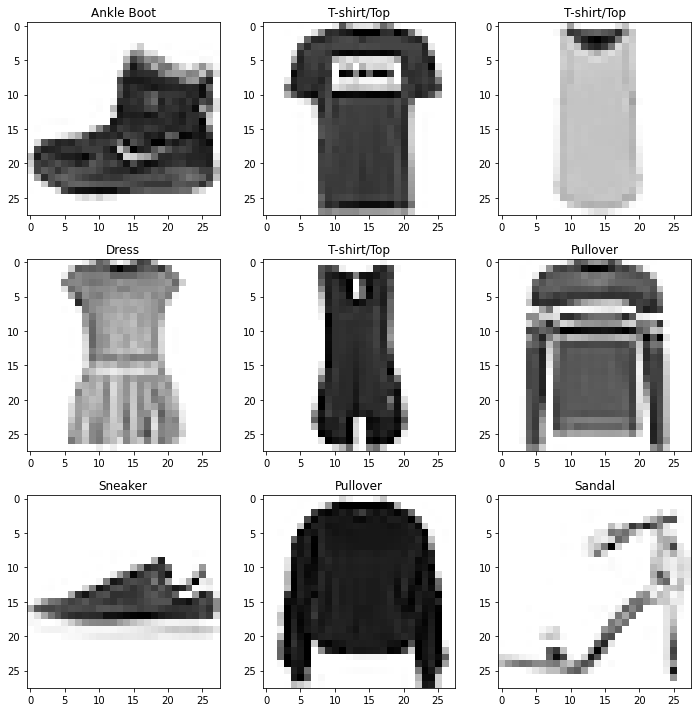

In [ ]:
# first plot the first 9 images in a grid
plt.figure(figsize = (10,10))
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(train_dataset[i][0].view(28,28), cmap="Greys")
  plt.title(lab_dict[train_dataset[i][1]])
plt.tight_layout()
plt.show()

## Prepare data


In [ ]:
# train_dataset.data = train_dataset.data[:1000]
# train_dataset.targets = train_dataset.targets[:1000]

In [ ]:
# create a validation set, since the dataset is relatively large. Training, validation split is 80 - 20.
torch.manual_seed(123)
np.random.seed(123)

batch_size = 10

train_dataset, val_dataset = split_data(train_dataset,val_size = 0.2)

#train_sampler = SubsetRandomSampler(train_idx)
#val_sampler = SubsetRandomSampler(val_idx)

#train_loader = DataLoader(train_dataset,batch_size = batch_size,sampler = train_sampler, shuffle = False,num_workers = 0)
#val_loader = DataLoader(train_dataset,batch_size = batch_size,sampler = val_sampler,shuffle = False, num_workers = 0)

train_loader = DataLoader(train_dataset,batch_size = batch_size,shuffle = True,num_workers = 0)
val_loader = DataLoader(val_dataset,batch_size = batch_size,shuffle = False,num_workers = 0)
test_loader = DataLoader(test_dataset,batch_size = batch_size,shuffle = False,num_workers = 0)

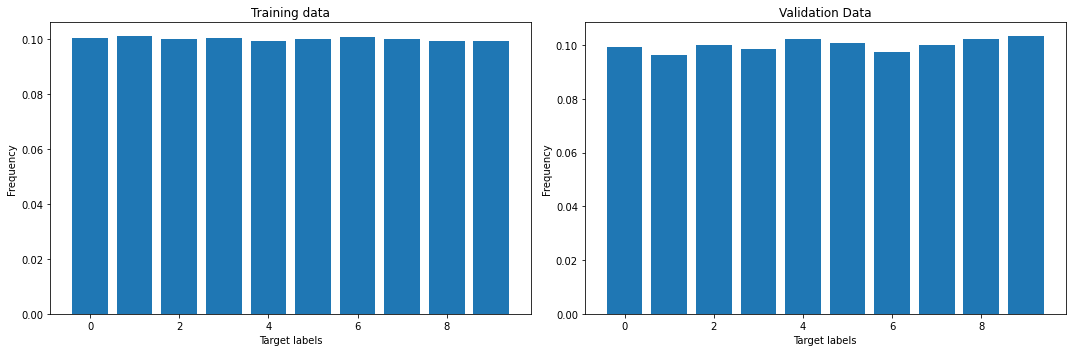

In [ ]:
# check distribution of labels in the training and validation set
class_count_train = count_classes(train_dataset)
class_count_val = count_classes(val_dataset)

plt.figure(figsize = (15,5))
plt.subplot(121)
plt.bar(x = range(10),height = class_count_train)
plt.xlabel("Target labels")
plt.ylabel("Frequency")
plt.title("Training data")

plt.subplot(122)
plt.bar(x = range(10),height = class_count_val)
plt.xlabel("Target labels")
plt.ylabel("Frequency")
plt.title("Validation Data")

plt.tight_layout()
plt.show() 

## Multi Layer Perceptron

### Simple Network

In [ ]:
torch.manual_seed(123)
Ni = 28*28
No = 10
hidden_layer_params = {0:1024,1:1024,2:512,3:128}
act_fn = nn.ReLU # set the activation function
n_epochs = 50

mlp_cl = MLP(Ni,No,hidden_layer_params,act_fn)

loss_fn = nn.CrossEntropyLoss() # cross entropy loss since it is a classification
optimiser = optim.Adam(mlp_cl.parameters(), lr= 1e-4) # Adam optimiser with learning rate of 0.0001

train_loss, train_acc, val_loss, val_acc = run_training_cl(n_epochs,mlp_cl,optimiser,loss_fn,device,
                          train_loader = train_loader, val_loader = val_loader)

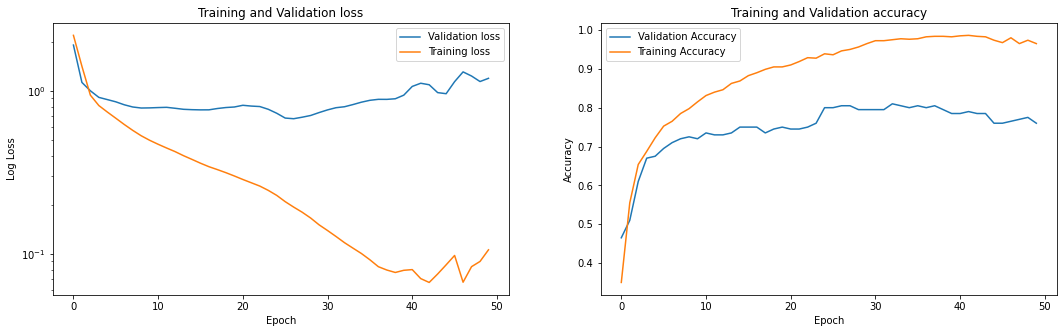

The model achieved the lowest validation loss in epoch 26: 0.675895
The model achieved the highest validation accuracy in epoch 32: 0.810000
Training loss in last epoch 1.196425
Trainin accuracy in last epoch 0.760000
The network has 2445194 parameters to train.


In [ ]:
plot_class_results(train_loss, train_acc, val_loss, val_acc)
get_best_period(val_loss,val_acc)
print(f"Training loss in last epoch {val_loss[-1]:6f}")
print(f"Trainin accuracy in last epoch {val_acc[-1]:6f}")
print(f"The network has {get_n_params(mlp_cl)} parameters to train.")

Training was too long, the model overfitted the data. Could have achieved a lower validation loss if the model had stoped training earlier. This would also have saved computing times. Thus introduce early stopping, which stops as soon as the validation loss no longer decreases. Moreover, introduce dropout to regularise the model and prevent overfitting further.

### Introduce Early Stopping, weight initialisation and regularisation


In [ ]:
torch.manual_seed(123)
Ni = 28*28
No = 10
hidden_layer_params = {0:1024,1:1024,2:512,3:128}
act_fn = nn.ReLU # set the activation function
max_epochs = 50

mlp_cl = MLP(Ni,No,hidden_layer_params,act_fn)
mlp_cl.apply(init_weights_kaiming) # add weight initialisation to increase speed of convergence

loss_fn = nn.CrossEntropyLoss() # cross entropy loss since it is a classification
optimiser = optim.Adam(mlp_cl.parameters(), lr= 1e-4) # Adam optimiser with learning rate of 0.0001

early_stopper = EarlyStopper(path='checkpoint.pt', patience=10)
train_loss, train_acc, val_loss, val_acc = run_training_cl(max_epochs,mlp_cl,optimiser,loss_fn,device,
                          train_loader = train_loader, val_loader = val_loader,early_stopper = early_stopper)

Initialising training


Loading the best model...
Validation loss 0.696456
Validation accuracy 0.845000
Patience exhausted. Stopping early...
Finished training after 17 seconds


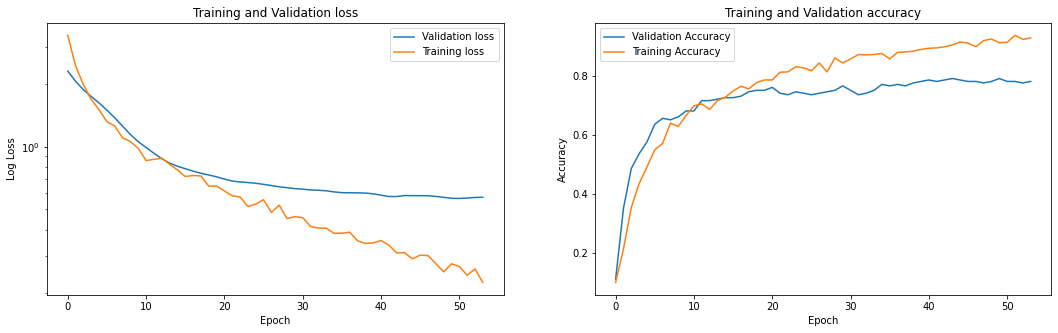

The model achieved the lowest validation loss in epoch 50: 0.564725
The model achieved the highest validation accuracy in epoch 43: 0.790000
Training loss in last epoch 0.572119
Trainin accuracy in last epoch 0.780000


NameError: ignored

In [ ]:
plot_class_results(train_loss, train_acc, val_loss, val_acc)
get_best_period(val_loss,val_acc)
print(f"Training loss in last epoch {val_loss[-1]:6f}")
print(f"Trainin accuracy in last epoch {val_acc[-1]:6f}")
print(f"The network has {get_n_params(mlp_cl)} parameters to train.")

Weight initialisation speeds up the convergence of the model and also increases the accuracy of the model on the validation set by ... percentage points. Early stopping enables efficient training in order to reduce overfitting on the one side and save computational cost. However, the model has more than 2 million parameters to adjust during training, which is a lot more than the number of images in the training sample. Thus, I introduce regularisation to reduce overfitting of the model. First I try out drop out, followed by weight decay as well as a combination of both.

In [ ]:
torch.manual_seed(123)
# The network architecture is the same as before. 
mlp_cl = MLP(Ni,No,hidden_layer_params,act_fn,dropout = 0.3) # set dropout rate to 0.3
mlp_cl.apply(init_weights_kaiming) # initialise weights using kaiming initialisation

loss_fn = nn.CrossEntropyLoss() # cross entropy loss since it is a classification
optimiser = optim.Adam(mlp_cl.parameters(), lr= 1e-4) # Adam optimiser with learning rate of 0.0001

early_stopper = EarlyStopper(path='checkpoint.pt', patience=10)
train_loss, train_acc, val_loss, val_acc = run_training_cl(max_epochs,mlp_cl,optimiser,loss_fn,device,
                          train_loader = train_loader, val_loader = val_loader, early_stopper = early_stopper)

Initialising training


Loading the best model...
Validation loss 0.588957
Validation accuracy 0.855000
Patience exhausted. Stopping early...
Finished training after 20 seconds


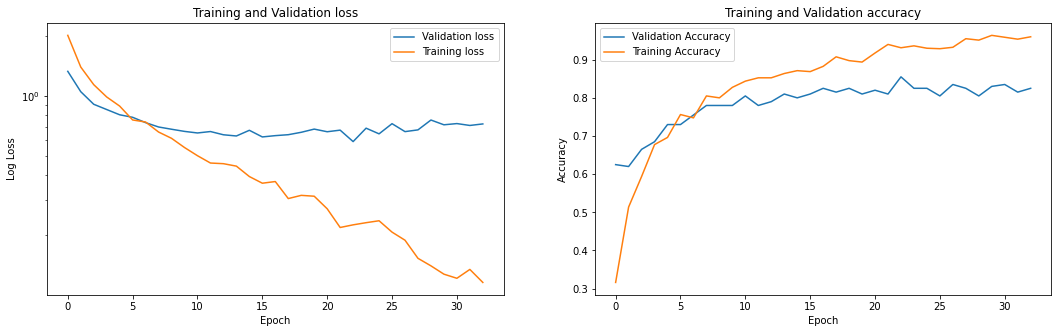

The model achieved the lowest validation loss in epoch 22: 0.588957
The model achieved the highest validation accuracy in epoch 22: 0.855000


In [ ]:
plot_class_results(train_loss,train_acc,val_loss,val_acc)
get_best_period(val_loss,val_acc)

We see that the validation accuracy follows much more the training accuracy than before, which indicates less overfitting of the model. Indeed, the model achieves a even higher validation accuracy compared to the model without dropout. However, the model might react differntly to different dropout rates. Thus, I will compare model performance using different dropout rates.

In [ ]:
torch.manual_seed(123)

# keep the same network parameters as before just update the dropout rate.
do_rates = [0.2,0.3,0.4,0.7]

tr_loss_do, tr_acc_do = np.zeros((len(do_rates),max_epochs)) * np.nan, np.zeros((len(do_rates),max_epochs)) * np.nan
val_loss_do, val_acc_do = np.zeros((len(do_rates),max_epochs)) * np.nan, np.zeros((len(do_rates),max_epochs)) * np.nan

for j,do_rate in enumerate(do_rates):
  print(f"Evaluate dropout rate {j+1} of {len(do_rates)}:{do_rate}")
  mlp_cl = MLP(Ni,No,hidden_layer_params,act_fn,dropout = do_rate) # set dropout rate to 0.3
  mlp_cl.apply(init_weights_kaiming) # initialise weights using kaiming initialisation

  loss_fn = nn.CrossEntropyLoss() # cross entropy loss since it is a classification
  optimiser = optim.Adam(mlp_cl.parameters(), lr= 1e-4) # Adam optimiser with learning rate of 0.0001

  early_stopper = EarlyStopper(path='checkpoint.pt', patience=10)
  train_loss, train_acc, val_loss, val_acc = run_training_cl(max_epochs,mlp_cl,optimiser,loss_fn,device,
                            train_loader = train_loader, val_loader = val_loader, early_stopper = early_stopper)
  
  ep = len(train_loss)
  tr_loss_do[j,:ep], tr_acc_do[j,:ep], val_loss_do[j,:ep], val_acc_do[j,:ep] = train_loss, train_acc, val_loss, val_acc
  print("")

Evaluate dropout rate 0 of 4
Initialising training


Loading the best model...
Validation loss 0.647633
Validation accuracy 0.845000
Patience exhausted. Stopping early...
Finished training after 22 seconds

Evaluate dropout rate 1 of 4
Initialising training


Loading the best model...
Validation loss 0.724323
Validation accuracy 0.835000
Patience exhausted. Stopping early...
Finished training after 25 seconds

Evaluate dropout rate 2 of 4
Initialising training


Loading the best model...
Validation loss 0.602867
Validation accuracy 0.845000
Patience exhausted. Stopping early...
Finished training after 23 seconds

Evaluate dropout rate 3 of 4
Initialising training


Finished training after 28 seconds



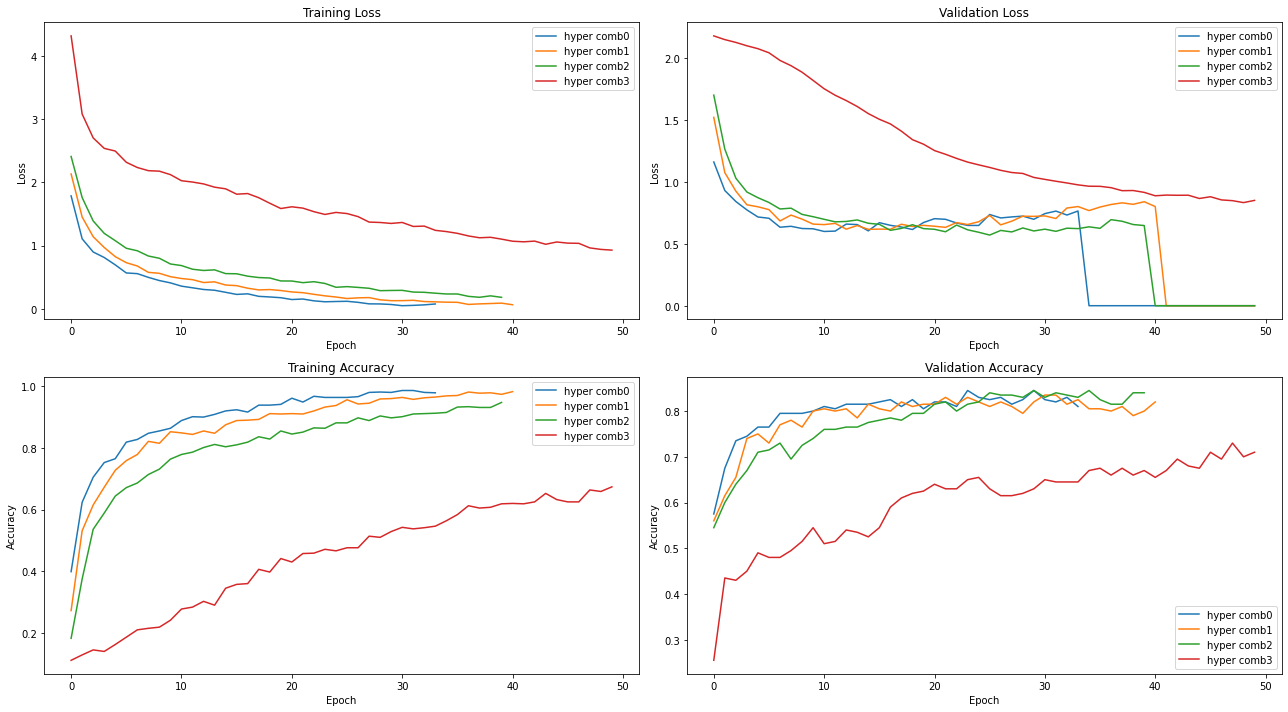

In [ ]:
plot_class_hyper(tr_loss_do, tr_acc_do, val_loss_do, val_acc_do)       

We see that a high drop out rate generally reduces the speed of training, while the lower dropout rates achieve all similar results within comparable number of epochs. Sometimes researchers combine dropout with weight decay, which I will do in the following. For this I will use the dropout rate with the lowest validation error, i.e. validation loss of 0.4.

In [ ]:
torch.manual_seed(123)

# keep the same network parameters as before just update the dropout rate.
decays = [0.001,0.01,0.1,0.2]

tr_loss_dec, tr_acc_dec = np.zeros((len(do_rates),max_epochs)) * np.nan, np.zeros((len(do_rates),max_epochs)) * np.nan
val_loss_dec, val_acc_dec = np.zeros((len(do_rates),max_epochs)) * np.nan, np.zeros((len(do_rates),max_epochs)) * np.nan

for j,decay in enumerate(decays):
  print(f"Evaluate weight decay {j+1} of {len(decays)}: {decay}")
  mlp_cl = MLP(Ni,No,hidden_layer_params,act_fn,dropout = 0.4) # set dropout rate to 0.4
  mlp_cl.apply(init_weights_kaiming) # initialise weights using kaiming initialisation

  loss_fn = nn.CrossEntropyLoss() # cross entropy loss since it is a classification
  optimiser = optim.Adam(mlp_cl.parameters(), lr= 1e-4,weight_decay = decay) # Adam optimiser with learning rate of 0.0001

  early_stopper = EarlyStopper(path='checkpoint.pt', patience=10)
  train_loss, train_acc, val_loss, val_acc = run_training_cl(max_epochs,mlp_cl,optimiser,loss_fn,device,
                            train_loader = train_loader, val_loader = val_loader, early_stopper = early_stopper)
  
  ep = len(train_loss)
  tr_loss_dec[j,:ep], tr_acc_dec[j,:ep], val_loss_dec[j,:ep], val_acc_dec[j,:ep] = train_loss, train_acc, val_loss, val_acc
  print("")

Evaluate weight decay 1 of 4: 0.001
Initialising training


Loading the best model...
Validation loss 0.636493
Validation accuracy 0.845000
Patience exhausted. Stopping early...
Finished training after 27 seconds

Evaluate weight decay 2 of 4: 0.01
Initialising training


Finished training after 30 seconds

Evaluate weight decay 3 of 4: 0.1
Initialising training


Loading the best model...
Validation loss 1.004990
Validation accuracy 0.670000
Patience exhausted. Stopping early...
Finished training after 14 seconds

Evaluate weight decay 4 of 4: 0.2
Initialising training


Loading the best model...
Validation loss 1.371047
Validation accuracy 0.650000
Patience exhausted. Stopping early...
Finished training after 10 seconds



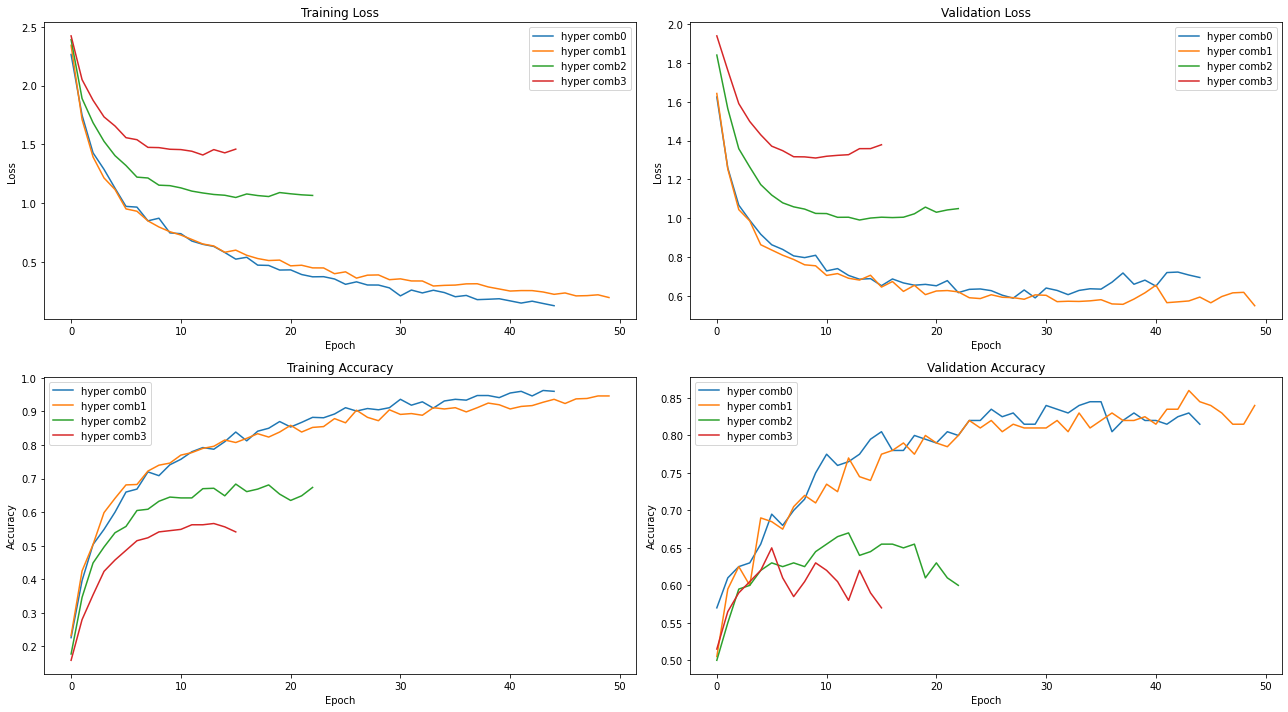

In [ ]:
plot_class_hyper(tr_loss_dec, tr_acc_dec, val_loss_dec, val_acc_dec)       

Combining weight decay with dropout does not seem to provide major improvements to the classification model. Thus just stick to dropout. However, there are many more hyper parameters to tune, such as the learning rate, patience of the early stopper, as well as the number of hidden layers or the number of nodes at each hidden layer. However, I set the learning rate and the patience parameter heuristically. In the following I will alter the network architecture to see whether this alters the performance of the network. There is an infinite number of combinations that I could try out, however the computational cost to run an exhaustive search over the entire parameter space is prohibitive, thus I will just restrain myself to comparing 4 random combinations and present the results here. 

### Tune hyper parameters

In [ ]:
# define random state
torch.manual_seed(123)
np.random.seed(123)

# hyper-parameters to tune:
# number of hidden layers, number of nodes per hidden layer
# activation function 
# learning rate
# regularisation using weight decay

# define number of hyper parameter combinations that I would like to try out
n_mods = 4
max_epochs = 50

hyper = []

# sample number of hidden layers
layer_space = [4,6,8,10]
hyper.append(np.random.choice(layer_space,n_mods))

# sample number of nodes for each hidden layer
nodes = []
node_space = [128,256,512,1024]
for j in range(n_mods):
  nodes.append(np.random.choice(node_space,hyper[-1][j]))
  #nodes.append(np.random.randint(10,500,hyper[-1][j]))

# sample initial learning rate
hyper.append([1e-4] * n_mods)

# dropoutrate can be between 0 and 1, thus sample value between zero and one
hyper.append(np.random.uniform(0.2,0.6,n_mods))

# weight decay
hyper.append([0] * n_mods)

# patience
hyper.append([10] * n_mods)

train_loss_hyper, train_acc_hyper, val_loss_hyper, val_acc_hyper = tune_params(hyper,max_epochs)

  0%|          | 0/4 [00:00<?, ?it/s]


evaluate hyper parameter combination 1
model structure: {0: 128, 1: 512, 2: 512, 3: 256, 4: 1024, 5: 512, 6: 1024, 7: 256}
learning_rate 0.000100, dropout_rate: 0.270181, weight_decay: 0.000000,patience = 10
Initialising training


 25%|██▌       | 1/4 [00:37<01:52, 37.38s/it]

Finished training after 37 seconds

evaluate hyper parameter combination 2
model structure: {0: 512, 1: 256, 2: 128, 3: 256, 4: 512, 5: 1024}
learning_rate 0.000100, dropout_rate: 0.412621, weight_decay: 0.000000,patience = 10
Initialising training


 50%|█████     | 2/4 [01:07<01:06, 33.03s/it]

Finished training after 30 seconds

evaluate hyper parameter combination 3
model structure: {0: 256, 1: 128, 2: 512, 3: 128, 4: 1024, 5: 256, 6: 1024, 7: 512}
learning_rate 0.000100, dropout_rate: 0.412731, weight_decay: 0.000000,patience = 10
Initialising training


 75%|███████▌  | 3/4 [01:21<00:24, 24.45s/it]

Loading the best model...
Validation loss 2.256412
Validation accuracy 0.315000
Patience exhausted. Stopping early...
Finished training after 14 seconds

evaluate hyper parameter combination 4
model structure: {0: 256, 1: 128, 2: 128, 3: 128, 4: 128, 5: 256, 6: 1024, 7: 1024}
learning_rate 0.000100, dropout_rate: 0.453760, weight_decay: 0.000000,patience = 10
Initialising training


100%|██████████| 4/4 [01:39<00:00, 24.93s/it]

Loading the best model...
Validation loss 2.260030
Validation accuracy 0.255000
Patience exhausted. Stopping early...
Finished training after 18 seconds


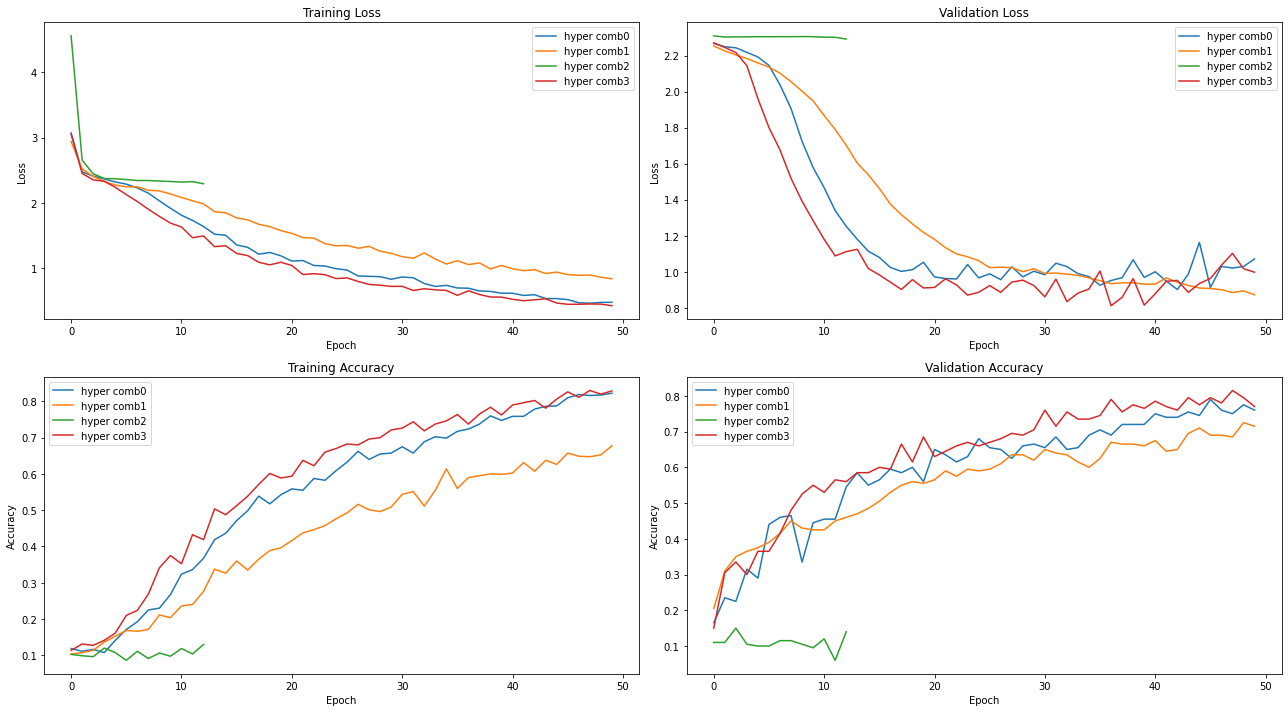

In [ ]:
plot_class_hyper(train_loss_hyper,train_acc_hyper,val_loss_hyper,val_acc_hyper)

## Convolutional Neural Network

In [ ]:
class ConvNet(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
                                nn.BatchNorm2d(32),
                                nn.ReLU())
    self.conv2 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
                                nn.BatchNorm2d(64),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size = 2, stride = 2))
    self.conv3 = nn.Sequential(nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 0),
                               nn.BatchNorm2d(64),
                               nn.ReLU(),
                               nn.MaxPool2d(kernel_size = 2, stride = 2))
    self.fc1 = nn.Sequential(nn.Linear(in_features = 64*6*6, out_features = 28*28),
                             nn.Dropout2d(0.25),
                             nn.ReLU())
    self.fc2 = nn.Sequential(nn.Linear(in_features = 28*28, out_features = 128),
                             nn.Dropout2d(0.15),
                             nn.ReLU())
    self.fc3 = nn.Linear(in_features = 128, out_features = 10)
  
  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

In [ ]:
torch.manual_seed(123)
max_epochs = 100

conv_net = ConvNet()
conv_net.apply(init_weights_kaiming)

loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(conv_net.parameters(), lr= 1e-3)

early_stopper = EarlyStopper(path='checkpoint.pt', patience=10)
train_loss, train_acc, val_loss, val_acc = run_training_cl(max_epochs,conv_net,optimiser,loss_fn,device,
                          train_loader = train_loader, val_loader = val_loader, early_stopper = early_stopper)
conv_net_res = np.array([train_loss, train_acc, val_loss, val_acc])
np.save("results/conv_net_res.npy",conv_net_res)
torch.save(conv_net.state_dict(), "results/conv_net.pt")

Initialising training


Loading the best model...
Validation loss 0.241124
Validation accuracy 0.927292
Patience exhausted. Stopping early...
Finished training after 4392 seconds


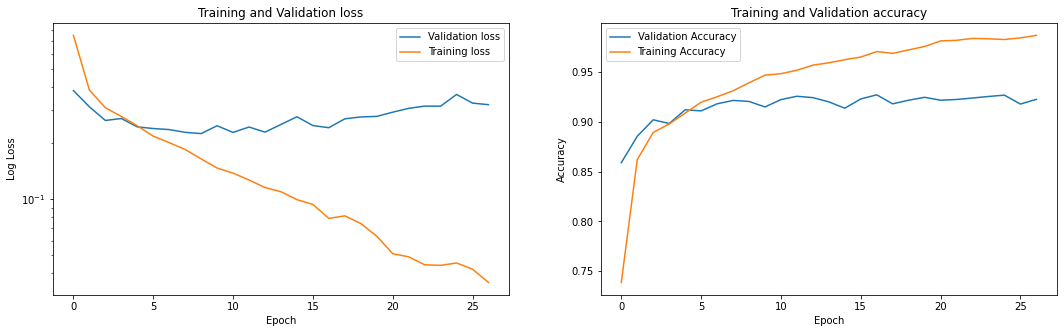

In [ ]:
plot_class_results(train_loss, train_acc, val_loss, val_acc)

In [ ]:
train_loss, train_acc, val_loss, val_acc = np.load("results/conv_net_res.npy")
conv_net = ConvNet()
state_conv_net = torch.load("results/conv_net.pt")
conv_net.load_state_dict(state_conv_net)

<All keys matched successfully>

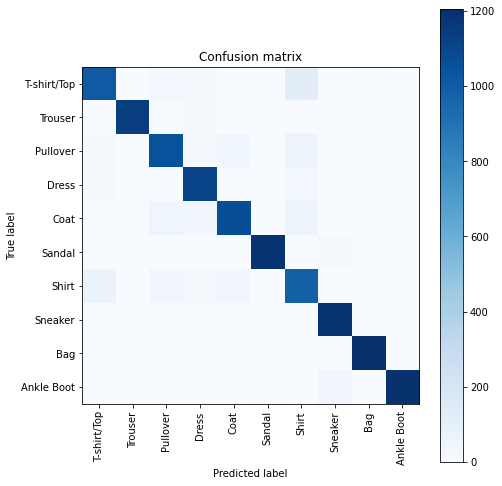

In [ ]:
y_true,y_hat = predict_cl(val_loader,conv_net,device)
cm = get_confusion(y_true, y_hat)
plot_confusion(cm,lab_dict)

In [ ]:
get_classification_report(cm,lab_dict)

Classification report

Overall Accuracy	92.77%

       Class	Precision 	Recall 		Support
 T-shirt/Top	89.95 % 	85.03 % 	1189
     Trouser	99.48 % 	98.70 % 	1154
    Pullover	89.21 % 	87.65 % 	1198
       Dress	90.73 % 	94.42 % 	1182
        Coat	91.51 % 	86.89 % 	1228
      Sandal	98.34 % 	97.93 % 	1210
       Shirt	76.62 % 	84.02 % 	1170
     Sneaker	95.40 % 	98.42 % 	1202
         Bag	98.61 % 	98.21 % 	1228
  Ankle Boot	98.76 % 	96.21 % 	1239

   Macro Avg	92.86 % 	92.75 % 	12000
Weighted Avg	92.92 % 	92.77 % 	12000


In [ ]:
fig = plt.figure(constrained_layout=True)

subfigs = fig.subfigures(2, 2)

for outerind, subfig in enumerate(subfigs.flat):
    subfig.suptitle(f'Subfig {outerind}')
    axs = subfig.subplots(2, 1)
    for innerind, ax in enumerate(axs.flat):
        ax.set_title(f'outer={outerind}, inner={innerind}', fontsize='small')
        ax.set_xticks([])
        ax.set_yticks([])
 
plt.show()

AttributeError: ignored

<Figure size 432x288 with 0 Axes>

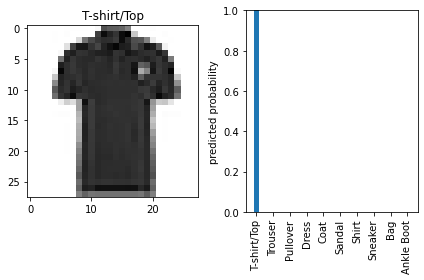

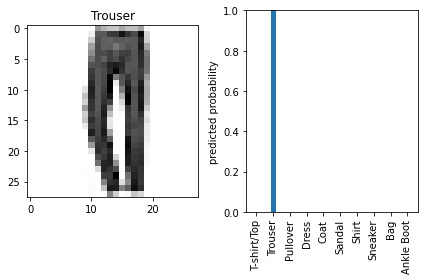

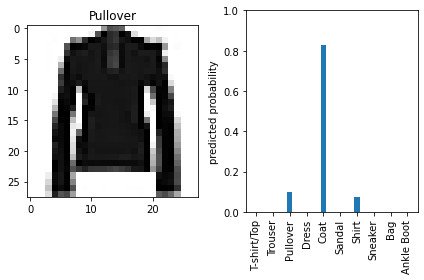

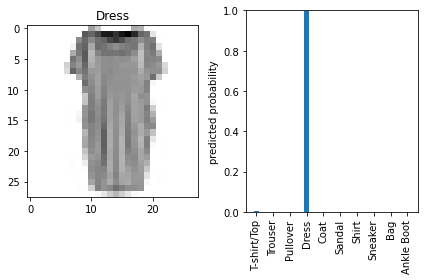

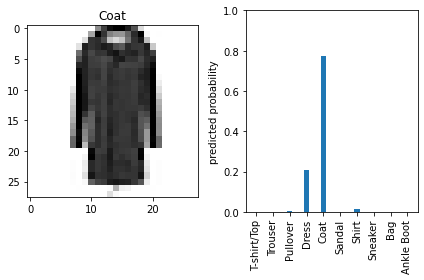

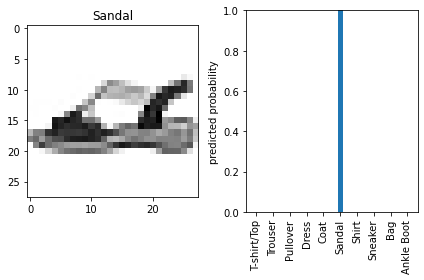

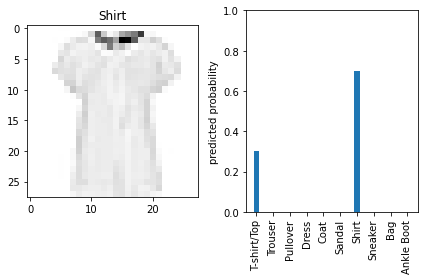

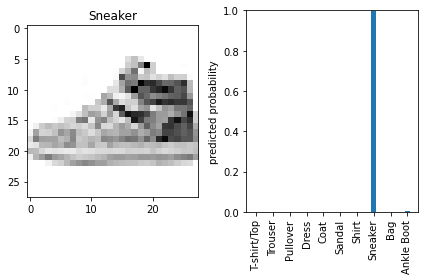

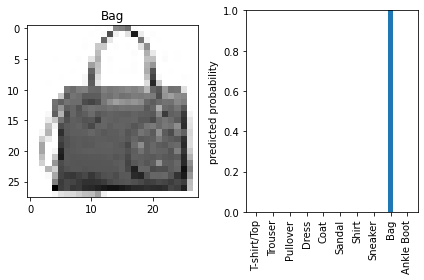

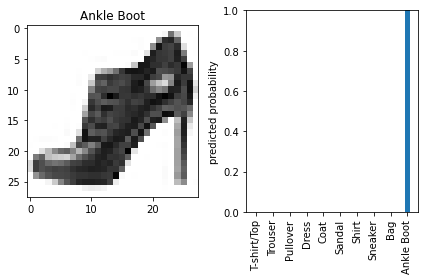

In [ ]:
for j in range(10):
  img, target = sample_random_cl(j,val_dataset)
  y_hat = predict_soft(img,conv_net,device)
  plot_img_probs(img,target,y_hat,lab_dict)

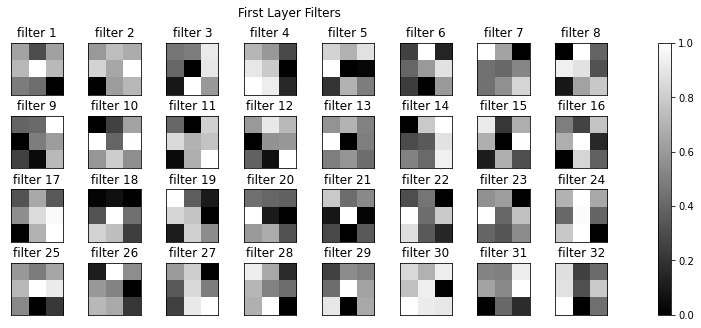

In [ ]:
def norm_min_max(kernel):
  return((kernel - kernel.min())/(kernel.max() - kernel.min()))
fig, ax = plt.subplots(4,8, figsize = (18,5),
                       subplot_kw={'xticks': [], 'yticks': []})
it = 0
for j in ax.reshape(-1):
  kernel = conv_net.conv1[0].weight[it].detach().cpu().numpy().reshape(3,3)
  kernel = norm_min_max(kernel)
  _ = j.imshow(kernel,cmap='gray')
  j.set_title('filter '+str(it+1))
  it += 1
plt.subplots_adjust(wspace=-0.7, hspace=0.4)
plt.colorbar(_,ax=ax.ravel().tolist())
plt.suptitle("First Layer Filters")
plt.show()

In [ ]:
acts = {}
def get_activation(name):
  def hook(layer,input,output):
    acts[name] = output.detach().cpu().numpy()
  return hook

conv1_hook = conv_net.conv1[0].register_forward_hook(get_activation('conv1'))
conv2_hook = conv_net.conv2.register_forward_hook(get_activation('conv2'))
conv3_hook = conv_net.conv3.register_forward_hook(get_activation('conv3'))
conv_net.eval()
with torch.no_grad():
  img, cl = next(iter(val_loader))
  _ = conv_net(img[5].unsqueeze(0).to(device))
conv1_hook.remove()
conv2_hook.remove()
conv3_hook.remove()

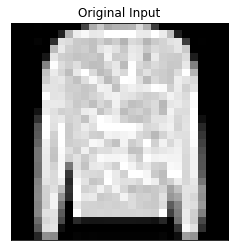

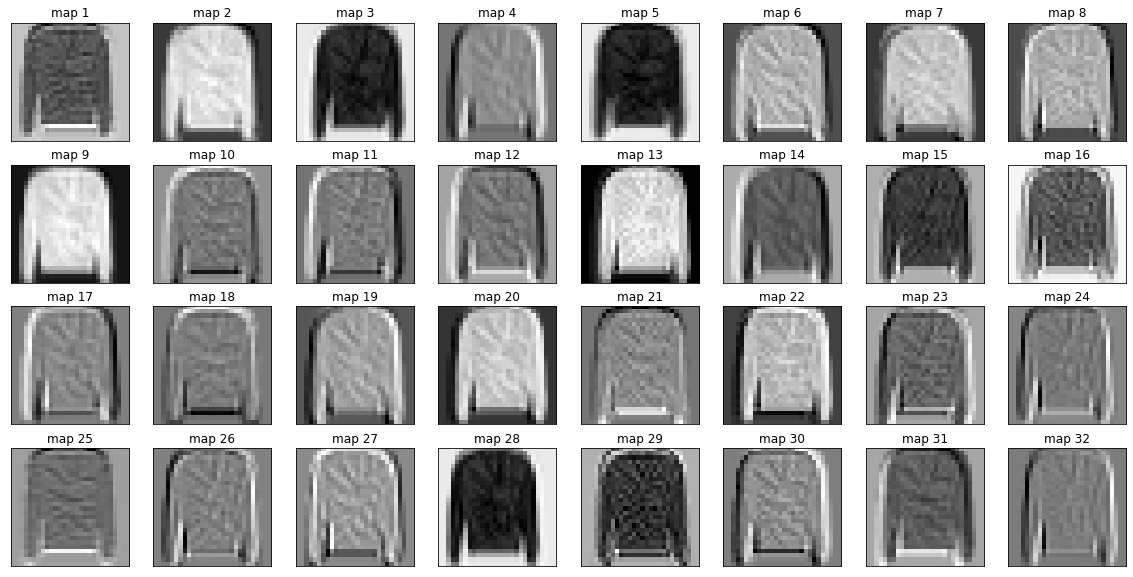

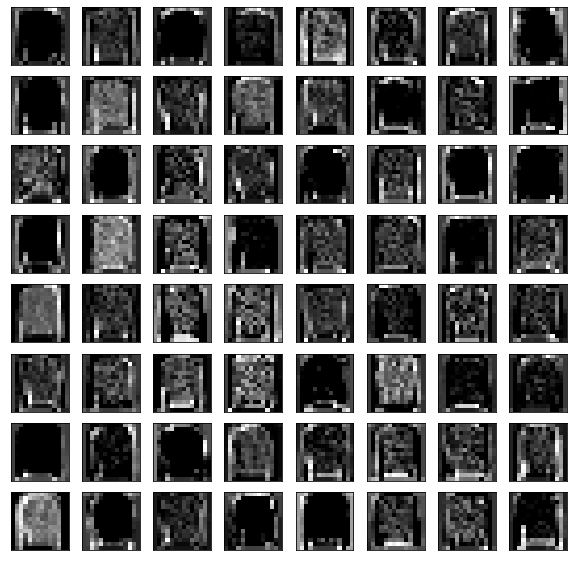

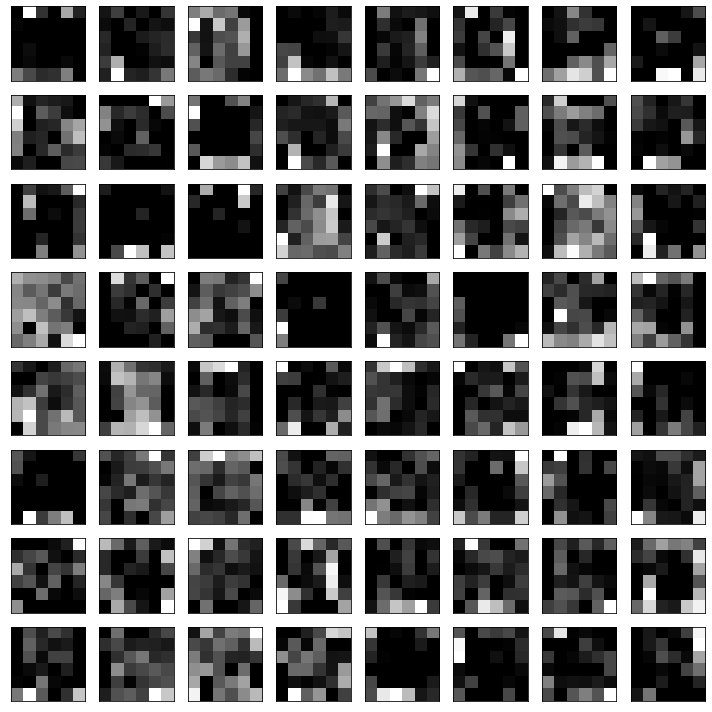

In [ ]:
plt.imshow(img[5].view(28,28),cmap = 'gray')
plt.title("Original Input")
plt.xticks([])
plt.yticks([])

fig, ax = plt.subplots(4,8,figsize = (20,10),
                       subplot_kw={'xticks': [], 'yticks': []})
it = 0
for j in ax.reshape(-1):
  _ = j.imshow(acts['conv1'][0][it], cmap = 'gray')
  j.set_title('map '+str(it+1))
  it += 1

fig2, ax2 = plt.subplots(8,8,figsize = (10,10),
                         subplot_kw ={'xticks':[], 'yticks':[]})
it = 0
for j in ax2.reshape(-1):
  _ = j.imshow(acts['conv2'][0][it], cmap = 'gray')
  it += 1

fig3, ax3 = plt.subplots(8,8,figsize = (10,10),
                         subplot_kw ={'xticks':[], 'yticks':[]})
it = 0
for j in ax3.reshape(-1):
  _ = j.imshow(acts['conv3'][0][it], cmap = 'gray')
  it += 1

plt.tight_layout()
plt.show()


In [ ]:
# rotate images to check accuracy (but maybe do that on test set?)